Charles Vin & Aymeric Delefosse <span style="float:right">DAC</span>

# <a id='toc1_'></a>[XAI - TME 2 : Explication par génération d'exemples contre-factuels divers](#toc0_)


**Table des matières**<a id='toc0_'></a>    
- [XAI - TME 2 : Explication par génération d'exemples contre-factuels divers](#toc1_)    
- [Modèles provenant de `sklearn`](#toc2_)    
- [Modèles neuronaux (`PyTorch`)](#toc3_)    
  - [Validation des exemples contrefactuels générés](#toc3_1_)    
    - [Validité](#toc3_1_1_)    
    - [Proximité](#toc3_1_2_)    
    - [Parcimonie](#toc3_1_3_)    
  - [Expérimentations](#toc3_2_)    
    - [Stabilité](#toc3_2_1_)    
  - [Variation des paramètres de DiCE](#toc3_3_)    
    - [Proximité](#toc3_3_1_)    
    - [Parcimonie](#toc3_3_2_)    
- [Growing Spheres](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import warnings

warnings.simplefilter("ignore")
import dice_ml
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

# <a id='toc2_'></a>[Modèles provenant de `sklearn`](#toc0_)


### Accuracy: 1.0


100%|██████████| 2/2 [00:00<00:00, 14.77it/s]


### Accuracy: 1.0


100%|██████████| 2/2 [00:00<00:00, 16.61it/s]


### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:18<00:00,  9.30s/it]


### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 15.83it/s]


### Accuracy: 0.9


100%|██████████| 2/2 [00:20<00:00, 10.17s/it]


### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:19<00:00,  9.98s/it]


### Accuracy: 0.8333333333333334


100%|██████████| 2/2 [00:00<00:00, 12.74it/s]


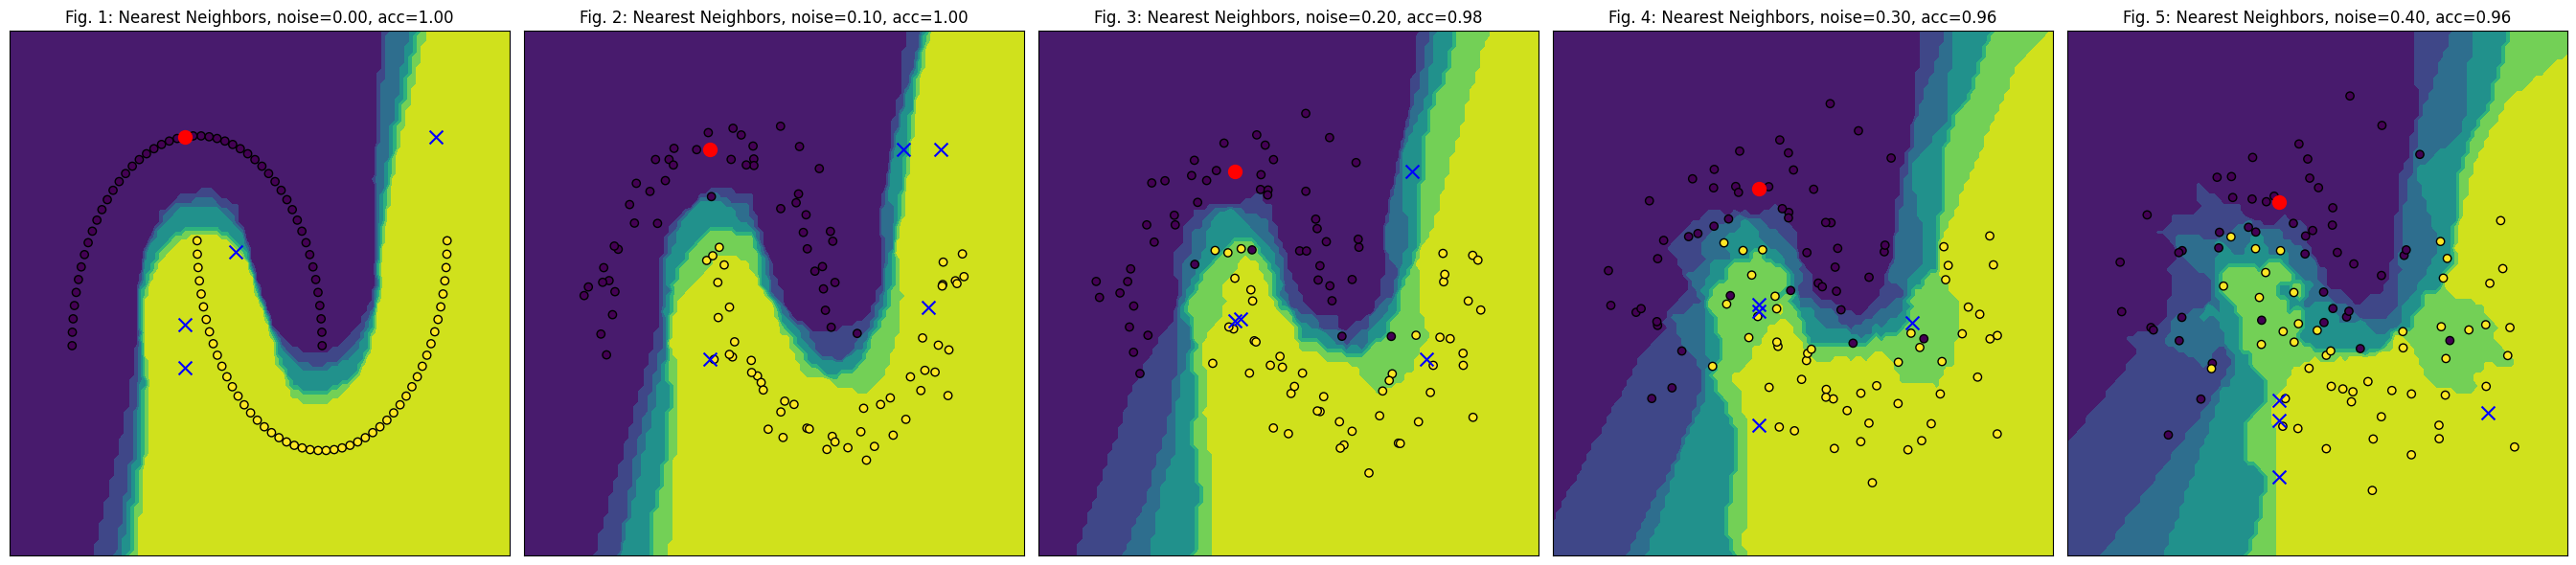

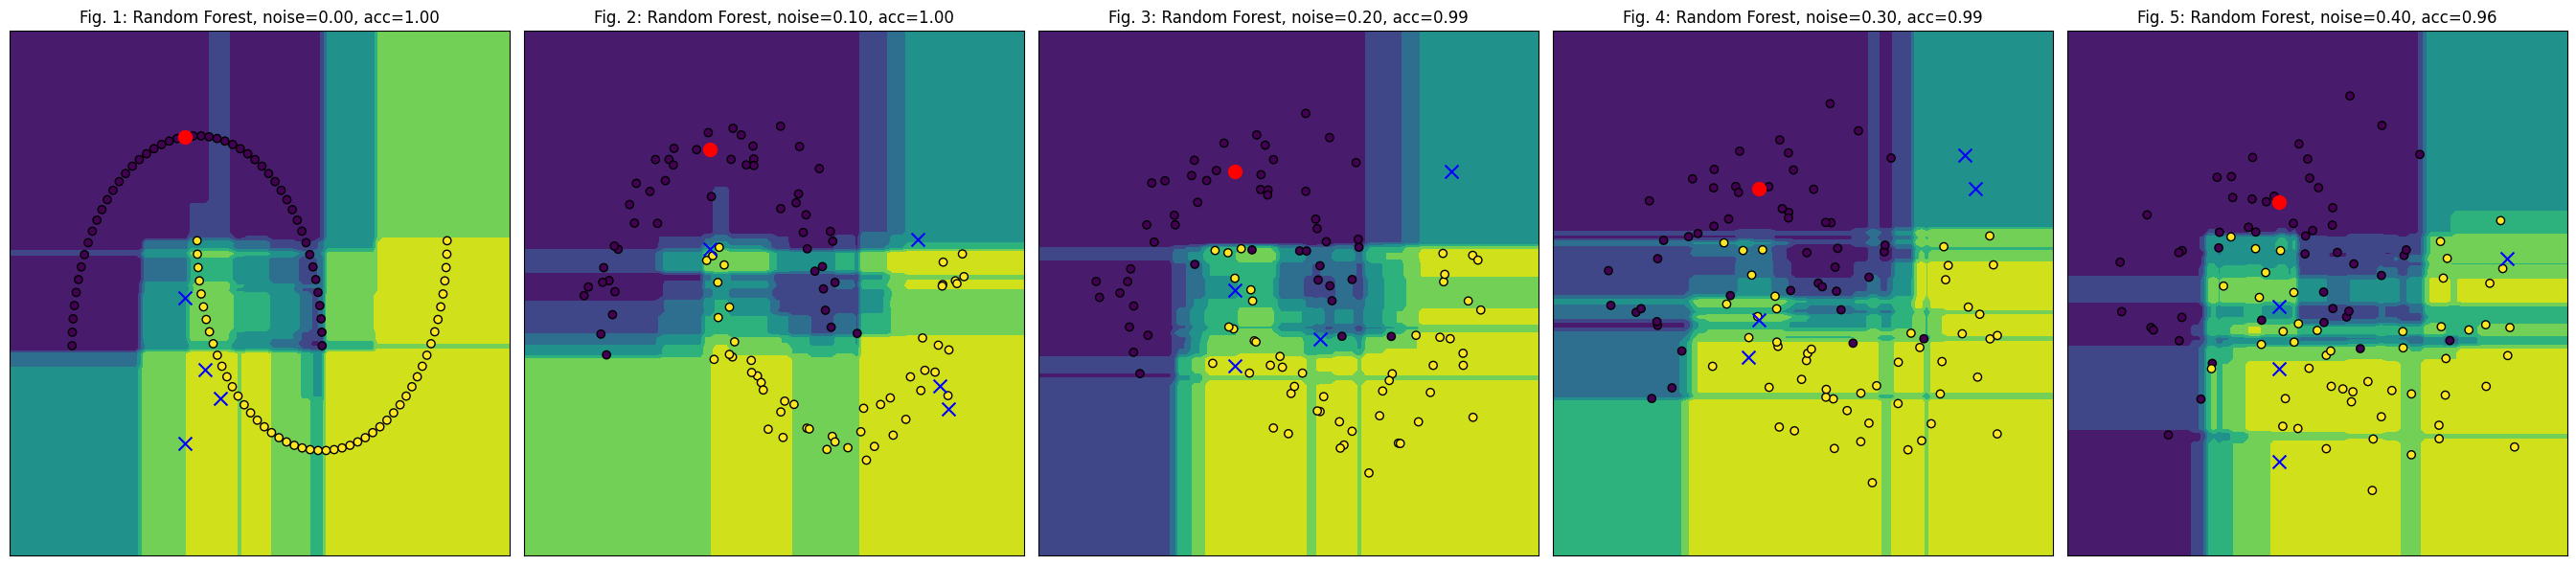

In [2]:
def visualize(
    X,
    y,
    clf,
    backend,
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    clf = clf.fit(X_train, y_train)
    print("### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return ax


names = [
    "Nearest Neighbors",
    "Random Forest",
    "SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    # SVC(),
]

## Création de jeux de données avec différents niveaux de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        X, y = dataset
        clf = clf.fit(X, y)
        ax = fig.add_subplot(1, len(datasets), i + 1)
        ax.set_title(f"Fig. {i+1}: {name}, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}")
        visualize(X, y, clf, "sklearn", ax=ax)
    fig.tight_layout()

Étant donné que les modèles proviennent de `scikit-learn`, l'interprétation des sorties de DiCE peut être complexe en raison de l'utilisation d'une méthode de tirage aléatoire.


# <a id='toc3_'></a>[Modèles neuronaux (`PyTorch`)](#toc0_)


Nous avons utilisé un réseau de neurones simples avec 16 couches cachées de la forme : **Linear** $\rightarrow$ **ReLU** $\rightarrow$ **Linear** $\rightarrow$ **Sigmoid**


In [9]:
from typing import Any
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # 2 input features, 16 hidden units
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)  # 1 output unit (binary classification)
        self.sig = nn.Sigmoid()

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.forward(*args, **kwds)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sig(x)
        return x

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()


# Generate synthetic data
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

In [10]:
def plot_boundaries_torch(X, y, ax, model):
    """Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(grid).numpy()
    Z = Z.reshape(xx.shape)

    # Plot the training points
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    # ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def train_torch_model(X_train, X_test, y_train, y_test, model, force=False):
    # Create the model
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    num_epochs = 2000

    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for the output

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (epoch + 1) % 100 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete")

    model.eval()  # Set the model to evaluation mode
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        test_outputs = model(test_inputs)
        predicted_labels = np.round(test_outputs)

    accuracy = (predicted_labels.detach().numpy() == y_test.reshape(-1, 1)).mean()
    print(f"### Test Accuracy: {accuracy * 100:.2f}%")
    if force and accuracy != 1:
        print(accuracy)
        print("Force = True, forcing train till good accuracy")
        model.reset()
        train_torch_model(X_train, X_test, y_train, y_test, model, force=True)


def gen_counterfactuals(
    df,
    model,
    total_CFs=4,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    sparsity_weight=0.2,
    permitted_range=None,
    posthoc_sparsity_param=0.1,
):
    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    dice_model = dice_ml.Model(model=model, backend="PYT")
    explainer = dice_ml.Dice(data, dice_model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=total_CFs,
        desired_class=desired_class,
        proximity_weight=proximity_weight,
        diversity_weight=diversity_weight,
        features_to_vary=features_to_vary,
        sparsity_weight=sparsity_weight,
        permitted_range=permitted_range,
        posthoc_sparsity_param=posthoc_sparsity_param,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    return enemy_df


def gen_data(X, y):
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return df, X_train, X_test, y_train, y_test


def visualize_torch(
    X,
    y,
    enemy_df,
    model,
    ax=None,
):
    if not ax:
        _, ax = plt.subplots()
    plot_boundaries_torch(X, y, ax, model)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)
    return ax

Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 15.45it/s]


Training complete
### Test Accuracy: 90.00%


100%|██████████| 2/2 [00:00<00:00, 19.53it/s]


Training complete
### Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 19.32it/s]


Training complete
### Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 19.44it/s]


Training complete
### Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 19.29it/s]


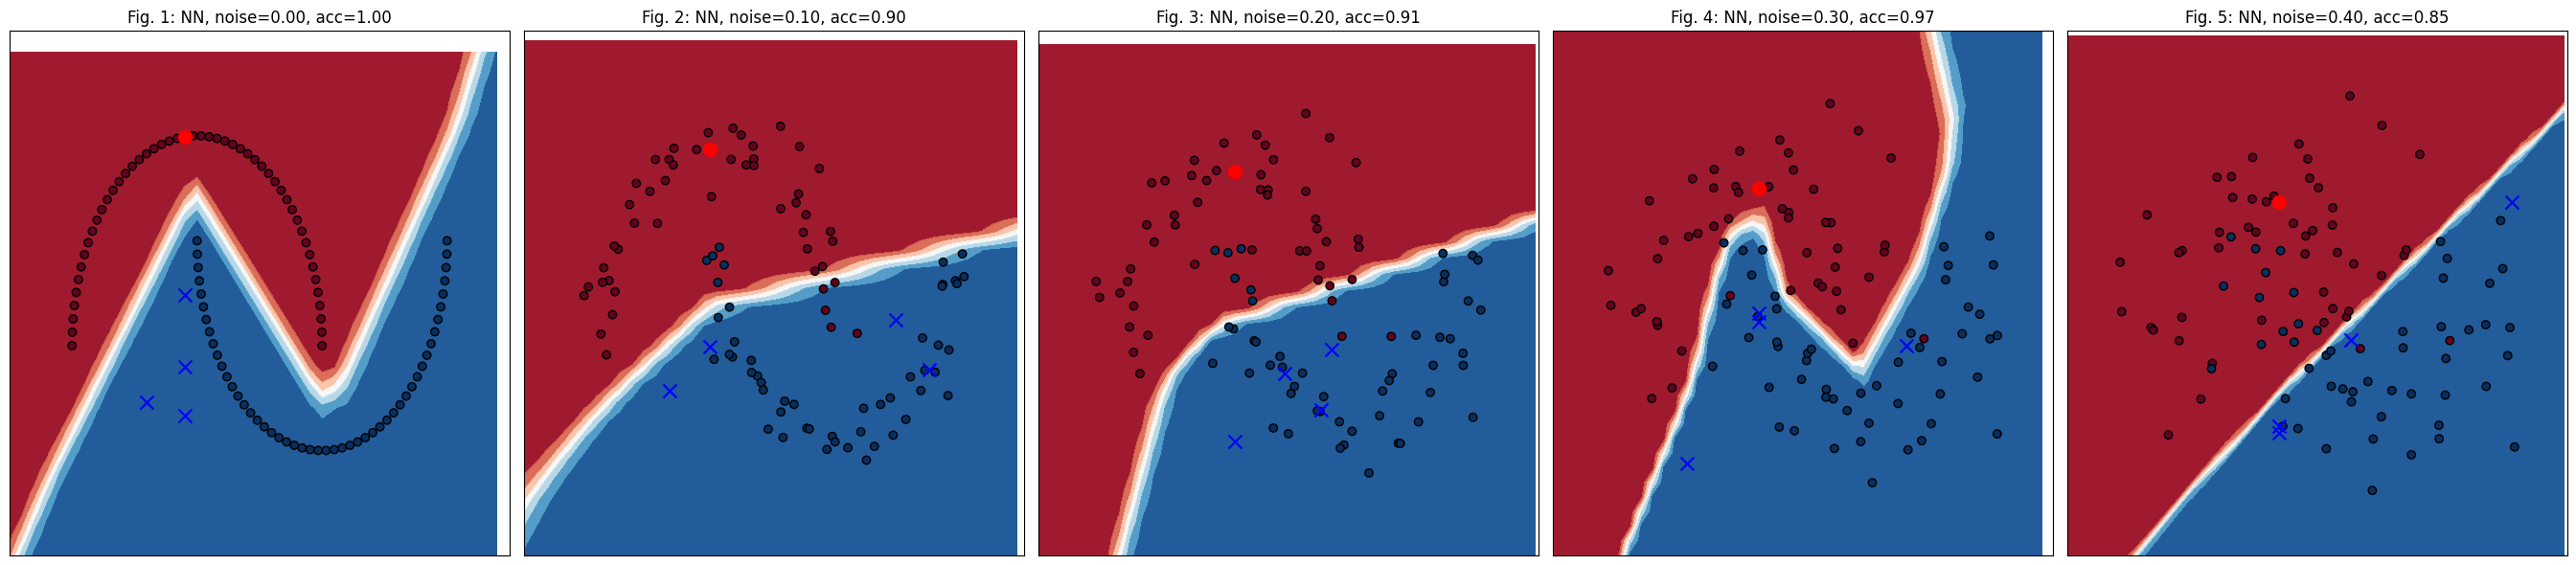

In [11]:
fig = plt.figure(figsize=(27, 6))

for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
    X, y = dataset
    ax = fig.add_subplot(1, len(datasets), i + 1)
    df, X_train, X_test, y_train, y_test = gen_data(X, y)
    model = SimpleNN()
    train_torch_model(X_train, X_test, y_train, y_test, model)
    preds = model(torch.Tensor(X)).round().detach().numpy()
    enemy_df = gen_counterfactuals(df, model)
    ax = visualize_torch(X, y, enemy_df, model, ax=ax)
    ax.set_title(f"Fig. {i+1}: NN, noise={noise:.2f}, acc={accuracy_score(y, preds):.2f}")
    visualize_torch(X, y, enemy_df, model, ax=ax)
fig.tight_layout()

## <a id='toc3_1_'></a>[Validation des exemples contrefactuels générés](#toc0_)


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:07<00:00,  3.94s/it]


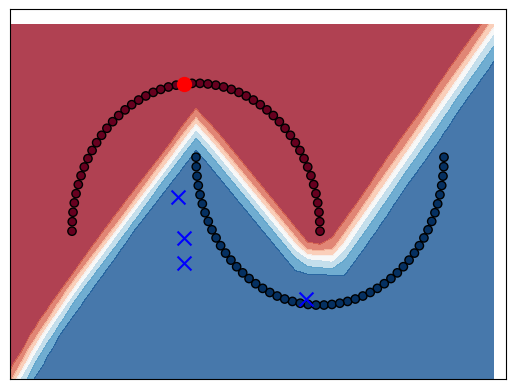

In [12]:
X, y = datasets[0]
clf = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, clf)
enemy_df = gen_counterfactuals(df, clf)
visualize_torch(X, y, enemy_df, clf)
obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

### <a id='toc3_1_1_'></a>[Validité](#toc0_)


Est-ce que les contrefactuels générés sont bien des contrefactuels, c'est-à-dire qu'ils n'appartiennent pas à la classe de l'exemple observé ?


In [13]:
def check_validity(enemy_df: pd.DataFrame, original_target: int):
    return enemy_df["Target"].values != original_target.values

### <a id='toc3_1_2_'></a>[Proximité](#toc0_)


In [15]:
def compute_distances(enemy_df: pd.DataFrame, target: pd.DataFrame):
    return np.linalg.norm(enemy_df.drop(columns="Target").values - target.values, axis=1)

### <a id='toc3_1_3_'></a>[Parcimonie](#toc0_)

Est-ce que les contrefactuels générés sont parcimonieux, c'est-à-dire est-ce qu'il y a un changement minimal dans les _features_ (ici les coordonnées) ? Les valeurs "1" indiquent un changement dans une seule coordonnée, tandis que les valeurs "2" indiquent que deux coordonnées ont changé simultanément.


In [17]:
def mesure_parcimony(enemy_df: pd.DataFrame, target: pd.DataFrame):
    return np.linalg.norm(enemy_df.drop(columns="Target").values - target.values, axis=1, ord=0)  # non zero elemt

## <a id='toc3_2_'></a>[Expérimentations](#toc0_)


**Protocole d'expérimentation** : pour un même modèle (ici, `SimpleNN`), une même donnée observée, on génère plusieurs exemples contrefactuels.


### <a id='toc3_2_1_'></a>[Stabilité](#toc0_)


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:15<00:00,  7.74s/it]


(array([[1.90123606, 1.15236393, 0.40000271, 1.3969949 ],
        [0.97284306, 1.43512388, 1.30468771, 0.82087265],
        [1.22848151, 0.6839764 , 0.77741765, 1.37682591],
        [0.85082331, 1.20288092, 0.93290305, 1.46556487],
        [1.34175908, 1.54776122, 1.29517715, 0.56926109],
        [2.37048054, 0.85422457, 1.05018   , 0.72252254],
        [0.98925462, 2.14474431, 1.48904064, 0.90176221],
        [1.45892863, 1.39367464, 0.72542103, 0.57062409],
        [0.91851969, 1.39067436, 0.92657123, 1.43229315],
        [0.85670814, 2.37728435, 0.91266098, 1.65349485],
        [0.63882501, 0.65887916, 1.82455334, 0.66687529],
        [1.06455864, 1.69851851, 0.80699439, 1.14522709],
        [2.43853172, 1.39828886, 1.4383826 , 1.4012353 ],
        [1.47566937, 2.13584089, 0.58145903, 0.72238683],
        [1.62027099, 1.76939953, 0.8749254 , 1.28671162],
        [2.1185848 , 1.27778493, 1.15749412, 2.13599648],
        [0.49503352, 0.73970877, 2.28286875, 2.32598171],
        [1.333

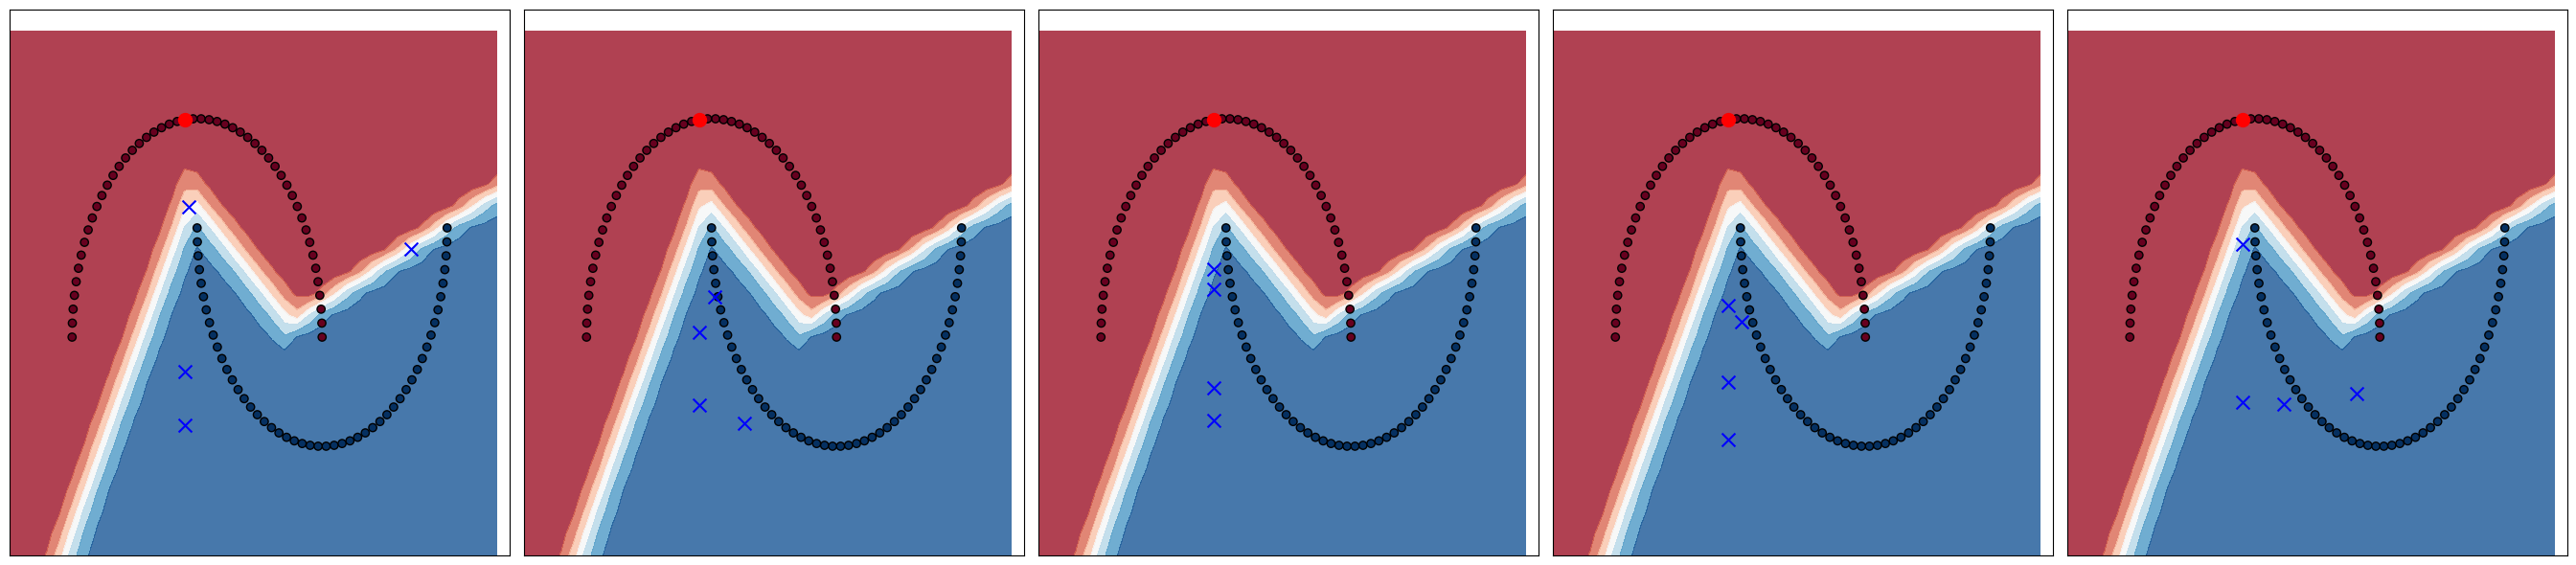

In [19]:
distance_list = []
mesure_parcimony_list = []
fig = plt.figure(figsize=(27, 6))
clf = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, clf, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, clf)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualize_torch(X, y, enemy_df, clf, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list.append(compute_distances(enemy_df, obs_to_interprete))
    mesure_parcimony_list.append(mesure_parcimony(enemy_df, obs_to_interprete))

distance_list = np.array(distance_list)
mesure_parcimony_list = np.array(mesure_parcimony_list)
fig.tight_layout()
distance_list, mesure_parcimony_list

Dans cette étude, notre objectif est d'évaluer la stabilité des exemples générés par l'algorithme DiCE. Nous allons procéder à une évaluation basée sur trois critères majeurs : la validité, la distance et la parcimonie, en effectuant un total de $n=20$ exécutions de DICE, chacune générant 5 exemples contrefactuels.

Tout d'abord, il convient de noter qu'aucun des $5 \times 20$ exemples contrefactuels générés au cours de ces exécutions n'a été catégorisé comme invalide. Plus précisément, cela signifie qu'aucun de ces exemples n'a été prédit dans la même classe que l'observation à expliquer, ce qui démontre la validité des contrefactuels générés.

En ce qui concerne l'évaluation de la distance, nous supposons que chaque échantillon parmi les 20 générés suit une distribution gaussienne avec une moyenne inconnue, mais présentant une variance homoscédastique commune. Pour déterminer si ces échantillons ont tous été générés avec la même moyenne, nous envisageons d'appliquer un test d'analyse de la variance (ANOVA).


In [20]:
import scipy.stats as stats

stats.f_oneway(*distance_list)

F_onewayResult(statistic=0.6831692637933402, pvalue=0.8204272309046957)

La valeur de la p-value est élevée ($>> 0.05$), ce qui nous amène à conserver l'hypothèse nulle qui postule l'absence de différence significative entre les groupes. Ainsi, il semble que DiCE présente une stabilité dans la génération de ces exemples.

Procédons de manière similaire pour évaluer la parcimonie.


In [21]:
stats.f_oneway(*mesure_parcimony_list)

F_onewayResult(statistic=0.5167464114832534, pvalue=0.9442790824160292)

Même commentaire.


---

Et en utilisant un nouveau réseau à chaque itération, on parvient aux mêmes conclusions.


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.54it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.43it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 17.06it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.70it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.16it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.79it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.82it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:15<00:00,  7.77s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.85it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.62it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:17<00:00,  8.86s/it]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


([array([1.29868185, 1.12108044, 1.17082307, 0.37368759]),
  array([2.05574662, 0.50800674, 0.78345727, 1.77930942]),
  array([1.81606641, 1.05282347, 0.82510059, 1.00333089]),
  array([1.40901412, 0.76439146, 1.41890069, 1.35851174]),
  array([0.87746067, 0.76097354, 2.19061948, 2.17106579]),
  array([2.33379083, 2.10117143, 1.57425158, 0.87589633]),
  array([1.27844549, 0.53719873, 0.46483467, 1.24600671]),
  array([1.48462933, 0.53917173, 1.05596176, 1.64147652]),
  array([0.85979131, 0.42803108, 0.76491606, 1.30058073]),
  array([0.37484562, 0.77492806, 1.3302486 , 0.77519087]),
  array([0.77628098, 0.54152075, 0.38564162, 0.79308656]),
  array([0.58540339, 1.32862883, 1.02038771, 1.46741102]),
  array([1.31603418, 0.45952808, 0.60612304, 0.43827608]),
  array([1.03818722, 1.25879564, 1.81565829, 0.86588638]),
  array([1.4475101 , 0.77585749, 1.18111587, 2.03956203]),
  array([1.2138449 , 0.8838491 , 0.99420838, 1.24757185]),
  array([0.40543546, 1.34627082, 0.63019825, 1.31464914]

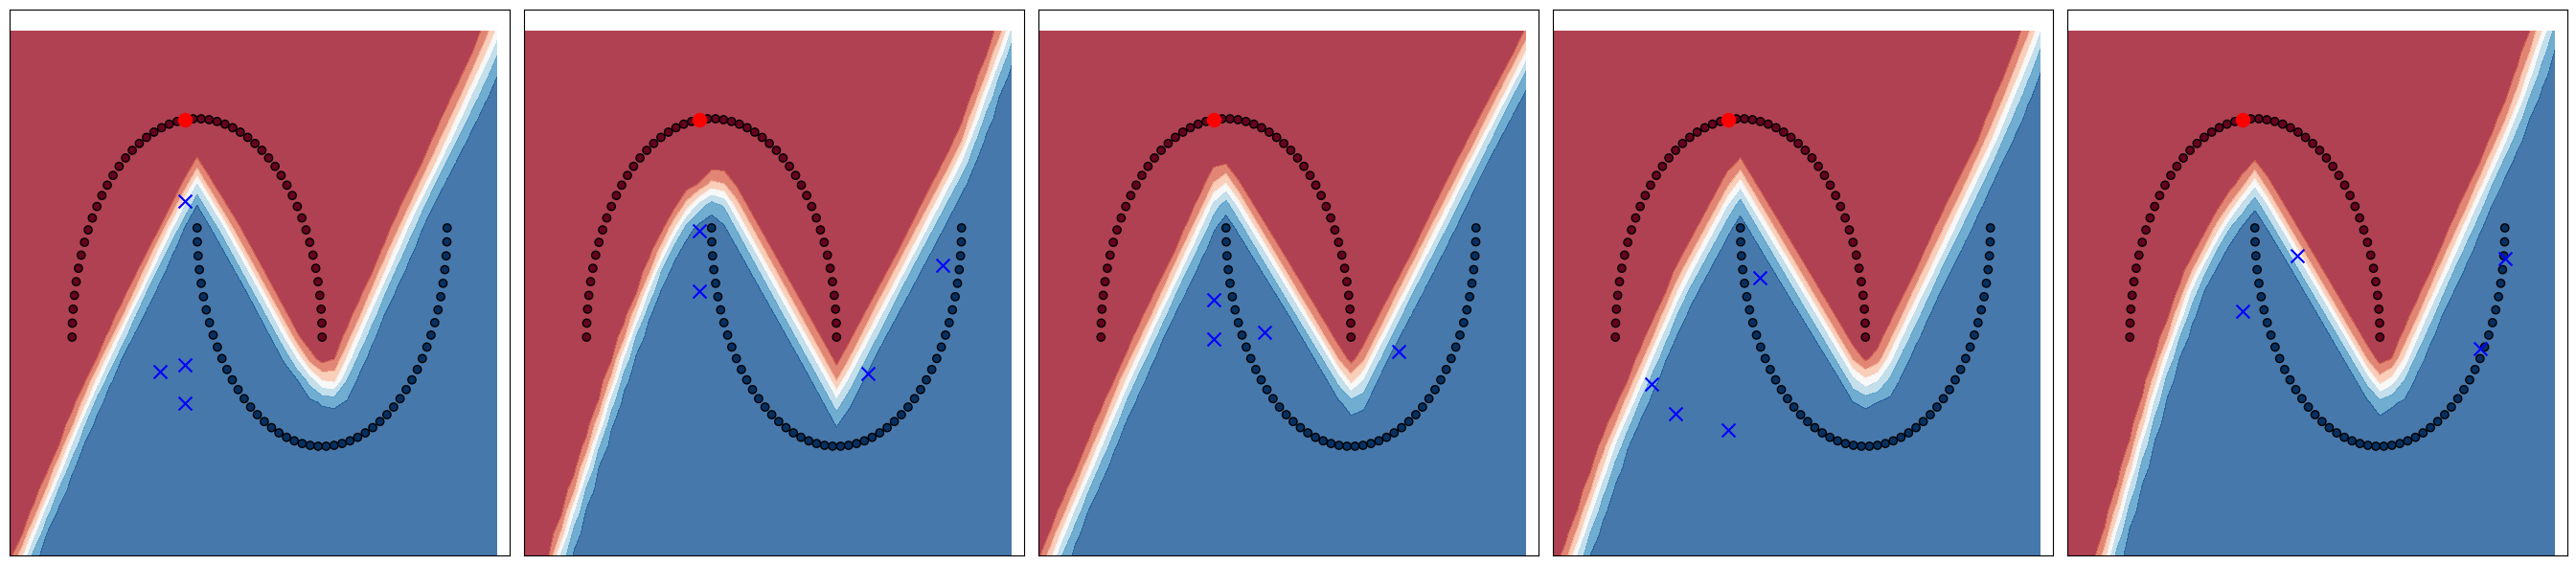

In [22]:
distance_list_retrain = []
mesure_parcimony_list_retrain = []
fig = plt.figure(figsize=(27, 6))

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]
X, y = datasets[0]
df, X_train, X_test, y_train, y_test = gen_data(X, y)

for i in range(20):
    clf = SimpleNN()
    train_torch_model(X_train, X_test, y_train, y_test, clf, force=True)

    # generate new enemies
    enemy_df = gen_counterfactuals(df, clf)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualize_torch(X, y, enemy_df, clf, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list_retrain.append(compute_distances(enemy_df, obs_to_interprete))
    mesure_parcimony_list_retrain.append(mesure_parcimony(enemy_df, obs_to_interprete))

fig.tight_layout()
distance_list_retrain, mesure_parcimony_list_retrain

In [23]:
stats.f_oneway(*distance_list_retrain), stats.f_oneway(*mesure_parcimony_list_retrain)

(F_onewayResult(statistic=1.2121460499164178, pvalue=0.2789212492831447),
 F_onewayResult(statistic=1.3636363636363638, pvalue=0.1805919421512962))

---


## <a id='toc3_3_'></a>[Variation des paramètres de DiCE](#toc0_)

Quel impact ont les paramètres sur notre méthode d'explication ?


- **total_CFs** – Total number of counterfactuals required.
- **desired_class** – Desired counterfactual class - can take 0 or 1. Default value is “opposite” to the outcome class of query_instance for binary classification.
- **desired_range** – For regression problems. Contains the outcome range to generate counterfactuals in. This should be a list of two numbers in ascending order.
- **permitted_range** – Dictionary with feature names as keys and permitted range in list as values. Defaults to the range inferred from training data. If None, uses the parameters initialized in data_interface.

- **features_to_vary** – Either a string “all” or a list of feature names to vary.
- **stopping_threshold** – Minimum threshold for counterfactuals target class probability.
- **proximity_weight** – A positive float. Larger this weight, more close the counterfactuals are to the query_instance. Used by [`genetic`, `gradientdescent`], ignored by [`random`, `kdtree`] methods.
- **sparsity_weight** – A positive float. Larger this weight, less features are changed from the query_instance. Used by [`genetic`, `kdtree`], ignored by [`random`, `gradientdescent`] methods.
- **diversity_weight** – A positive float. Larger this weight, more diverse the counterfactuals are. Used by [`genetic`, `gradientdescent`], ignored by [`random`, `kdtree`] methods.
- **categorical_penalty** – A positive float. A weight to ensure that all levels of a categorical variable sums to 1. Used by [`genetic`, `gradientdescent`], ignored by [`random`, `kdtree`] methods.
- **posthoc_sparsity_param** – Parameter for the post-hoc operation on continuous features to enhance sparsity.
- **posthoc_sparsity_algorithm** – Perform either linear or binary search. Takes “linear” or “binary”. Prefer binary search when a feature range is large (for instance, income varying from 10k to 1000k) and only if the features share a monotonic relationship with predicted outcome in the model.


### <a id='toc3_3_1_'></a>[Proximité](#toc0_)


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


array([[1.15179879, 2.11484955, 0.81014477, 0.53173852],
       [0.83894303, 2.03357561, 1.33646702, 1.4466548 ],
       [0.43375561, 2.18728025, 0.40964965, 0.50846647],
       [1.44906877, 0.63864097, 1.28910439, 1.15832636],
       [0.47213143, 0.91767318, 1.22157549, 1.09825532],
       [1.26590173, 0.83317139, 0.67241717, 2.0631847 ],
       [0.76461549, 0.94671971, 0.76895898, 1.1873336 ],
       [0.39266192, 1.2595919 , 0.83297139, 1.20092407],
       [2.0781775 , 1.07866835, 2.08383037, 0.62595684],
       [0.81600762, 0.86882624, 1.00705231, 0.96278615],
       [0.49160168, 0.94833281, 2.26198756, 0.35970521],
       [1.48379566, 0.74204043, 1.13177487, 0.73183295],
       [0.83110739, 1.07749326, 1.2395882 , 0.38061106],
       [1.21190698, 1.93308475, 1.35216874, 1.21784839],
       [0.58378086, 0.4637803 , 0.61967282, 0.88117038],
       [1.14306299, 1.18014274, 1.10290703, 0.64686289],
       [1.49204159, 0.51043121, 0.88004521, 0.78181394],
       [2.07305574, 1.29832252,

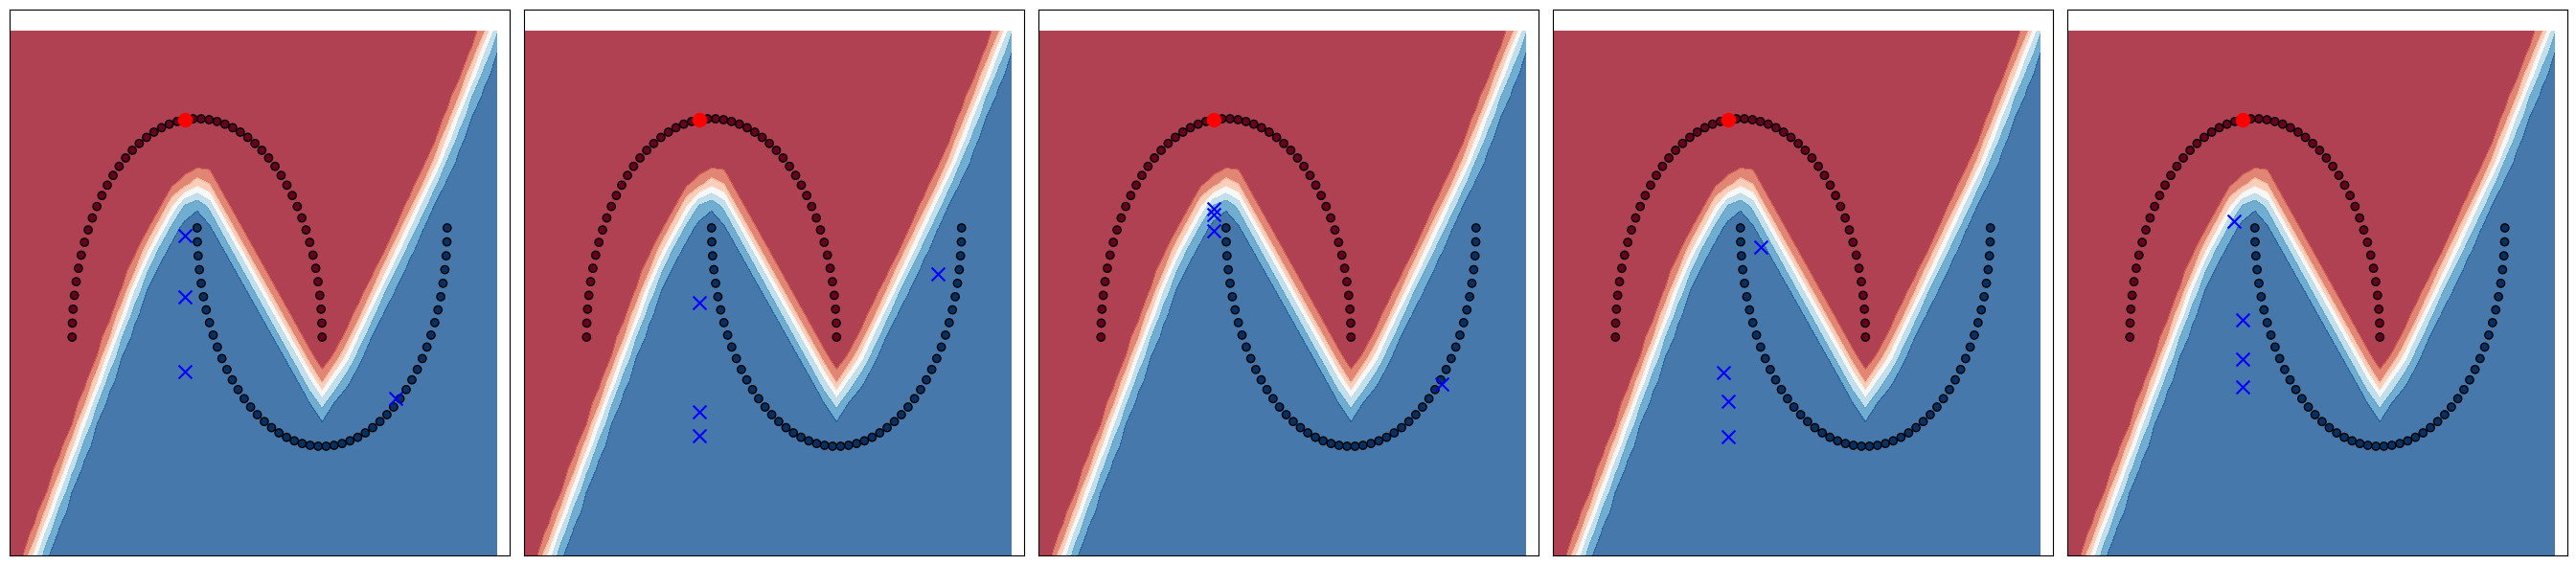

In [48]:
distance_list_new_parameter = []
fig = plt.figure(figsize=(27, 6))
clf = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, clf, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, clf, proximity_weight=0.8)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualize_torch(X, y, enemy_df, clf, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list_new_parameter.append(compute_distances(enemy_df, obs_to_interprete))
distance_list_new_parameter = np.array(distance_list_new_parameter)
fig.tight_layout()
distance_list_new_parameter

Utilisons un test t-test pour évaluer si la modification du paramètre de distance a effectivement un impact. Nous supposons une variance égale.


In [49]:
stats.ttest_ind(distance_list.mean(axis=1), distance_list_new_parameter.mean(1))

TtestResult(statistic=2.5036307515596237, pvalue=0.0167063093850193, df=38.0)

In [50]:
stats.ttest_ind(distance_list.mean(axis=1), distance_list_new_parameter.mean(1), equal_var=False)

TtestResult(statistic=2.503630751559624, pvalue=0.01670922712844249, df=37.97619370164189)

Le paramètre semble fonctionner de manière aléatoire. Les p-value sont parfois significatives ou non en fonction des essais. Nous avons vu $ p=0 < 0.01 $ comme $ p > 0.9 $. Voici un screenshot d'une p-value faible et d'une p-value élevée.

![](https://media.discordapp.net/attachments/1047111061314220033/1160950246940102766/image.png)

![Alt text](https://media.discordapp.net/attachments/1047111061314220033/1160952046581723277/image.png)

### <a id='toc3_3_2_'></a>[Parcimonie](#toc0_)


Training complete
### Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 19.14it/s]


array([[2., 2., 1., 1.],
       [2., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 2., 2., 2.],
       [2., 2., 2., 1.],
       [2., 1., 1., 1.],
       [2., 2., 2., 1.],
       [2., 1., 1., 1.],
       [2., 1., 2., 2.],
       [2., 1., 1., 2.],
       [1., 1., 1., 2.],
       [2., 2., 2., 1.],
       [1., 1., 1., 1.],
       [1., 2., 2., 1.],
       [2., 2., 2., 1.],
       [2., 1., 2., 2.],
       [1., 1., 2., 1.],
       [1., 1., 1., 2.],
       [1., 2., 1., 1.]])

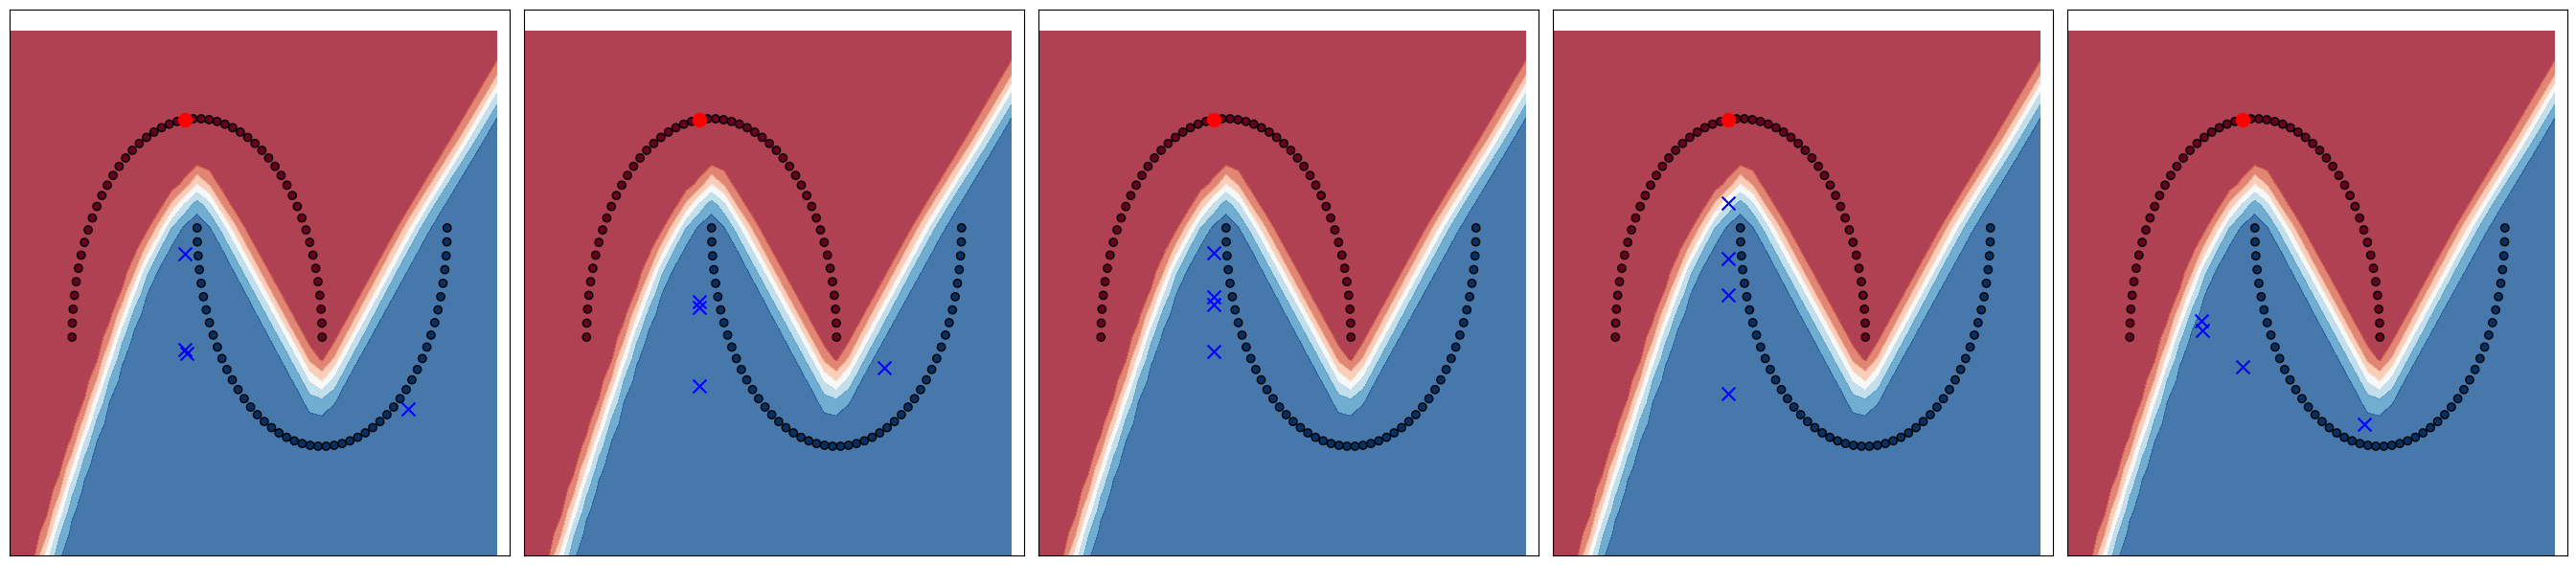

In [27]:
mesure_parcimony_list_new_parameter = []
fig = plt.figure(figsize=(27, 6))
clf = SimpleNN()
df, X_train, X_test, y_train, y_test = gen_data(X, y)
train_torch_model(X_train, X_test, y_train, y_test, clf, force=True)

obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]

for i in range(20):
    X, y = datasets[0]

    # generate new enemies
    enemy_df = gen_counterfactuals(df, clf, sparsity_weight=0.8)
    if i < 5:
        ax = fig.add_subplot(1, len(datasets), i + 1)
        visualize_torch(X, y, enemy_df, clf, ax=ax)

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    mesure_parcimony_list_new_parameter.append(mesure_parcimony(enemy_df, obs_to_interprete))
mesure_parcimony_list_new_parameter = np.array(mesure_parcimony_list_new_parameter)
fig.tight_layout()
mesure_parcimony_list_new_parameter

Même test que précédemment.


In [28]:
stats.ttest_ind(mesure_parcimony_list.mean(axis=1), mesure_parcimony_list_new_parameter.mean(axis=1))

TtestResult(statistic=-0.32950178841916733, pvalue=0.7435858675287016, df=38.0)

En agrégeant les données en comptant le nombre de "1" et en ignorant les "2" :


In [29]:
stats.ttest_ind((mesure_parcimony_list == 1).sum(axis=1), (mesure_parcimony_list_new_parameter == 1).sum(axis=1))

TtestResult(statistic=0.3295017884191659, pvalue=0.7435858675287026, df=38.0)

Observons en effectuant un comptage manuel :


In [30]:
pd.Series(mesure_parcimony_list.flatten()).value_counts(), pd.Series(
    mesure_parcimony_list_new_parameter.flatten()
).value_counts()

(1.0    48
 2.0    32
 dtype: int64,
 1.0    46
 2.0    34
 dtype: int64)

Pour rappel, les valeurs "1" indiquent qu'une seule coordonnée a changé, tandis que les valeurs "2" indiquent que deux coordonnées ont changé.

Il semble que la parcimonie n'ait pas varié malgré l'augmentation du paramètre de $0.2$ à $0.8$. Nous constatons que le nombre de "1" et de "2" dans les deux échantillons reste statistiquement inchangé (p-value $>> 0.5$).


# <a id='toc4_'></a>[Growing Spheres](#toc0_)


In [31]:
from ast import Dict


class GrowingSpheres:
    def __init__(
        self, model, eta, n, attribute_names: list, immutable_attrs: list = None, attribute_ranges: Dict = None
    ):
        self.model = model
        self.eta = eta
        self.n = n
        self.attribute_names = attribute_names
        self.immutable_attrs = immutable_attrs if immutable_attrs else []
        self.attribute_ranges = attribute_ranges if attribute_ranges else {}

    def generate_spherical_layer(self, a0, a1) -> torch.Tensor:
        def norm(v):
            return torch.norm(v, p=2, dim=1)

        z = torch.normal(0, 1, size=(self.n, self.d))
        u = torch.Tensor(np.random.uniform(a0**self.d, a1**self.d, size=self.n))
        u = u ** (1 / self.d)

        z = z * u.view(-1, 1) / norm(z).view(-1, 1)

        # Ensure that attributes stay within the specified ranges
        for attr_name in self.attribute_ranges.keys():
            if attr_name not in self.immutable_attrs:
                min_range, max_range = self.attribute_ranges[attr_name]
                attr_index = self.attribute_names.index(attr_name)
                if attr_index >= 0 and attr_index < z.shape[1]:
                    z[:, attr_index] = torch.clamp(z[:, attr_index], min_range, max_range)

        return self.obs_to_interprete + z

    def find_enemy(self, spherical_layer):
        with torch.no_grad():
            pred = (self.model(spherical_layer) > 0.5).float()  # Binary classification

        # Ensure that immutable attributes are not modified in the spherical_layer
        for attr_name in self.immutable_attrs:
            if attr_name in self.attribute_names:
                attr_index = self.attribute_names.index(attr_name)
                if attr_index >= 0 and attr_index < spherical_layer.shape[1]:
                    spherical_layer[:, attr_index] = self.obs_to_interprete[0, attr_index]

        self.enemies = spherical_layer[(pred != self.obs_predict).view(-1)]
        return (pred != self.obs_predict).any()

    def predict(self, obs_to_interprete):
        self.obs_to_interprete = torch.Tensor(obs_to_interprete).view(1, -1)
        self.obs_predict = (self.model(self.obs_to_interprete) > 0.5).float()  # Binary classification
        self.d = self.obs_to_interprete.shape[1]

        enemy = self.generation()
        return enemy.detach().numpy(), self.feature_selection(enemy)

    def generation(self):
        self.iter = 0
        spherical_layer = self.generate_spherical_layer(0, 1)
        while self.find_enemy(spherical_layer):
            self.eta /= 2
            spherical_layer = self.generate_spherical_layer(0, self.eta)
            self.iter += 1
        a0 = self.eta
        a1 = 2 * self.eta
        while not self.find_enemy(spherical_layer):
            spherical_layer = self.generate_spherical_layer(a0, a1)
            a0 = a1
            a1 = a1 + self.eta
            self.iter += 1
        return self.enemies[torch.norm(self.enemies - self.obs_to_interprete, p=2, dim=1).argmin()]

    def feature_selection(self, counterfactual):
        move_sorted = sorted(
            enumerate(abs(counterfactual - self.obs_to_interprete.view(-1))),
            key=lambda x: x[1],
        )
        move_sorted = [x[0] for x in move_sorted if x[1] > 0.0]
        out = counterfactual.clone()
        reduced = 0

        for k in move_sorted:
            new_enn = out.clone()
            new_enn[k] = self.obs_to_interprete.view(-1)[k]

            with torch.no_grad():
                new_pred = (self.model(new_enn.view(1, -1)) > 0.5).float()  # Binary classification

            if (new_pred == self.obs_predict).all():
                out[k] = new_enn[k]
                reduced += 1

        return out.detach().numpy()

<Axes: >

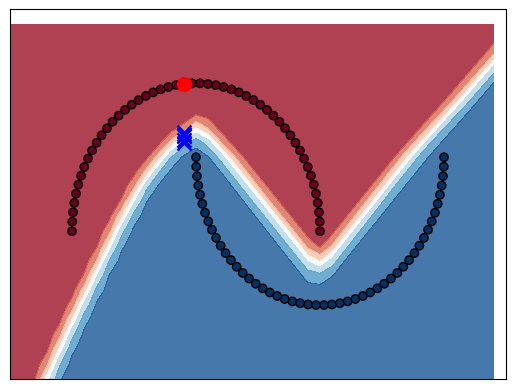

In [32]:
def find_enemies(
    obs_to_interpret, model, attribute_names, n=10, eta=2, n_gs=100, immutable_attrs=None, attribute_ranges=None
):
    enemies = []
    enemies_fs = []
    for _ in range(n):
        gs = GrowingSpheres(model, eta, n_gs, attribute_names, immutable_attrs, attribute_ranges)
        enemy, enemy_fs = gs.predict(obs_to_interpret)
        enemies.append(enemy)
        enemies_fs.append(enemy_fs)

    return pd.DataFrame(enemies, columns=attribute_names)


attribute_names = ["Feature1", "Feature2"]
enenmy_range = find_enemies(obs_to_interprete, clf, attribute_names, immutable_attrs=["Feature1"])
visualize_torch(X, y, enenmy_range, clf)

<Axes: >

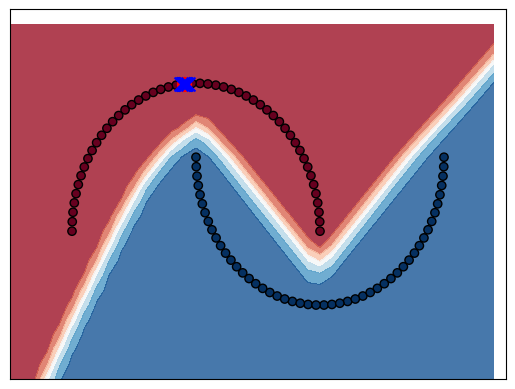

In [33]:
attribute_names = ["Feature1", "Feature2"]
enenmy_range = find_enemies(obs_to_interprete, clf, attribute_names, immutable_attrs=["Feature2"])
visualize_torch(X, y, enenmy_range, clf)

<Axes: >

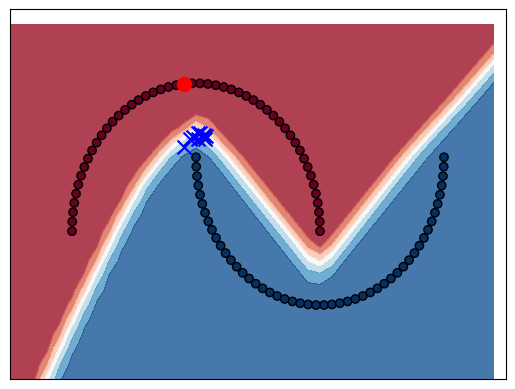

In [34]:
attribute_names = ["Feature1", "Feature2"]
enenmy_range = find_enemies(obs_to_interprete, clf, attribute_names, attribute_ranges={"Feature2": (-0.5, 0.5)})
visualize_torch(X, y, enenmy_range, clf)

<Axes: >

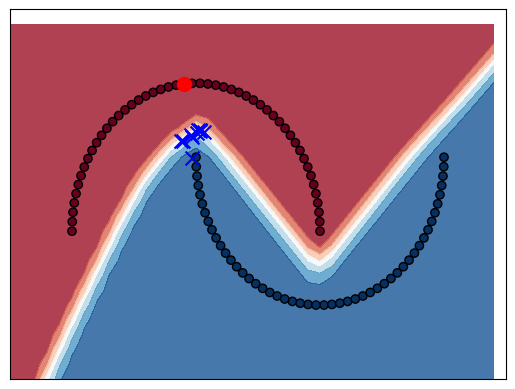

In [35]:
attribute_names = ["Feature1", "Feature2"]
enenmy_range = find_enemies(obs_to_interprete, clf, attribute_names, attribute_ranges={"Feature1": (-0.5, 0.5)})
visualize_torch(X, y, enenmy_range, clf)